In [13]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import ast
from datetime import datetime,timedelta
import mplcursors


In [23]:
def generate_filename(url, minutes, file_type='txt'):
    """
    Generate a filename based on the URL and duration.

    @param url: The URL of the meeting.
    @param minutes: Duration of the meeting in minutes.
    @param ext: The file extension for the generated file.
    @return: A string representing the generated filename.
    """
    # Sanitize the URL to remove or replace special characters
    sanitized_url = re.sub(r'[^\w\s-]', '', url.replace('/', '_').replace(':', '_'))
    return f"LoadTimes_{sanitized_url}_{minutes}min.{file_type}"



In [24]:
def plot_user_count(timestamps, load_times, data,url, minutes, TIME_LINE, PAUSE_TIME_EXCEED, PAUSE_TIME_NOT_EXCEED):
    """
    Plots user counts and loading times over time.

    @timestamps: List of timestamps in the format 'YYYY-MM-DD HH:MM:SS'.
    @load_times: List of loading times corresponding to the timestamps.
    @url: URL of the meeting.
    @minutes: Duration of the meeting in minutes.
    @TIME_LINE: Maximum acceptable loading time in seconds.
    @PAUSE_TIME_EXCEED: Pause time in seconds if loading time exceeds TIME_LINE.
    @PAUSE_TIME_NOT_EXCEED: Pause time in seconds if loading time does not exceed TIME_LINE.
    """
    print("Timestamps received:", timestamps)
    print(len(timestamps))

    # Initial timestamp processing
    start_time = datetime.strptime(timestamps[0], '%Y-%m-%d %H:%M:%S')
    end_time = datetime.strptime(timestamps[-1], '%Y-%m-%d %H:%M:%S')
    total_seconds = int((end_time - start_time).total_seconds())
    time_range = list(range(0, total_seconds + 1))
    relative_times = [(datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() for ts in timestamps]

    # Generate descriptive labels for each second
    relative_times_descriptive_filtered = [
        f"{int(t // 60)} Minute{'s' if int(t // 60) != 1 else ''}, {int(t % 60)} Second{'s' if int(t % 60) != 1 else ''}" 
        if int(t // 60) != 0 else f"{int(t % 60)} Second{'s' if int(t % 60) != 1 else ''}"
        for t in time_range
    ]
    
    # Update the first timestamp entry to "X:XXpm EST"
    relative_times_descriptive_filtered[0] = start_time.strftime('%I:%M%p EST')

    # Create the main plot
    fig, ax1 = plt.subplots(figsize=(15, 8))
    line1, = ax1.plot(relative_times, load_times, 'b-o', label='Loading Time (s)')
    ax1.set_xlabel('Time Elapsed')
    ax1.set_ylabel('Loading Time (s)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.axhline(y=TIME_LINE, color='r', linestyle='--', label=f'Max Acceptable Time ({TIME_LINE}s)')
    plt.xticks(rotation=45, ha='right')  # Adjusting x-tick labels for better readability
    ax1.set_xticks(time_range[::20])  # Adjust x-axis to show every 10 seconds for better readability
    ax1.set_xticklabels(relative_times_descriptive_filtered[::20])

    # Add transparent scatter plot for the horizontal line
    scatter = ax1.scatter(relative_times, [TIME_LINE] * len(relative_times), alpha=0)

    # Secondary axis for user counts
    ax2 = ax1.twinx()
    try:
        timestamp_dt = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamps]
        active_user = ast.literal_eval(data)
        time_ranges = [(datetime.strptime(entry[1], '%Y-%m-%d %H:%M:%S'), datetime.strptime(entry[2], '%Y-%m-%d %H:%M:%S')) for entry in active_user]
        
        # Calculate user counts for each second in the time range
        counts = [sum(start <= start_time + timedelta(seconds=t) <= end for start, end in time_ranges) for t in time_range]
        
        # Create bar plot for user counts, ensuring x-data is a list
        bars = ax2.bar(time_range, counts, color='g', alpha=0.6, label='User Count')
        ax2.set_ylabel('Count of Active Users', color='g')
        ax2.tick_params(axis='y', labelcolor='g')
        
    except Exception as e:
        print(f"Error parsing input: {e}")
        return
    
    # Titles and grid
    plt.title('Webpage Loading Times and User Counts Over Multiple Requests')
    ax1.grid(True)
    
    # Additional descriptive texts and formatting
    plt.figtext(0.5, 1.08, "Starting Time: " + relative_times_descriptive_filtered[0], 
                        horizontalalignment='center', fontsize=12, fontweight='bold')
    additional_text = (f"Meeting URL: {url}\n"
                       f"Duration (minutes): {minutes}\n"
                       f"Maximum acceptable response time (seconds): {TIME_LINE}\n"
                       f"Pause time if exceeds the time line (seconds): {PAUSE_TIME_EXCEED}\n"
                       f"Pause time if does not exceed the time line (seconds): {PAUSE_TIME_NOT_EXCEED}\n")
    plt.figtext(0.5, -0.1, additional_text, wrap=True, horizontalalignment='center', fontsize=10)
    
    # Add legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    # Add mplcursors for interactive display of values
    cursor = mplcursors.cursor([line1, *bars, scatter], hover=True)

    @cursor.connect("add")
    def on_add(sel):
        index = sel.index
        # Calculate the actual second index from the target
        sec_index = int(sel.target[0])
        load_time = load_times[relative_times.index(sec_index)] if sec_index in relative_times else None
        user_count = counts[sec_index]
        if sel.target[1] == TIME_LINE:
            sel.annotation.set_text(f'Time: {relative_times_descriptive_filtered[sec_index]}\nLoading Time: {load_time}s\nUser Count: {user_count}\nNote: This is the max acceptable time line')
        else:
            sel.annotation.set_text(f'Time: {relative_times_descriptive_filtered[sec_index]}\nLoading Time: {load_time}s\nUser Count: {user_count}')
        print(f'Interactive data: Time: {relative_times_descriptive_filtered[sec_index]}, Loading Time: {load_time}s, User Count: {user_count}')  # Debugging line

    # Layout and save
    plt.tight_layout()
    filename_png = "USER_COUNT" + generate_filename(url, minutes, 'png')
    plt.savefig(filename_png, bbox_inches='tight')
    print(f"Plot saved as {filename_png}")
    plt.show()

    

In [27]:
loading_time =[
    3, 11.86, 8.76, 8.94, 4.6, 13.81, 9.79, 10.77, 12.65, 18.14, 13.41, 8.12, 
    12.2, 13.72, 23.17, 18.15, 28.6, 7.29, 2.73, 2.61, 2.7, 2.6, 2.58, 4.26, 
    2.75, 2.55, 3.8, 5.87, 2.65, 2.63, 2.61, 2.5, 2.63, 3.1, 2.72, 2.88, 2.69, 
    3.92, 2.94, 2.78, 2.57, 3.53, 2.62, 2.5, 2.52, 2.55, 4.24, 2.54, 2.49, 
    2.59, 5.3, 2.68, 3, 3.43
]

 

timestamps = [
    "2024-08-02 17:42:07", "2024-08-02 17:42:15", "2024-08-02 17:42:31", 
    "2024-08-02 17:42:45", "2024-08-02 17:42:59", "2024-08-02 17:43:09", 
    "2024-08-02 17:43:28", "2024-08-02 17:43:43", "2024-08-02 17:43:58", 
    "2024-08-02 17:44:16", "2024-08-02 17:44:39", "2024-08-02 17:44:58", 
    "2024-08-02 17:45:11", "2024-08-02 17:45:28", "2024-08-02 17:45:47", 
    "2024-08-02 17:46:15", "2024-08-02 17:46:38", "2024-08-02 17:47:12", 
    "2024-08-02 17:47:24", "2024-08-02 17:47:32", "2024-08-02 17:47:39", 
    "2024-08-02 17:47:47", "2024-08-02 17:47:55", "2024-08-02 17:48:02", 
    "2024-08-02 17:48:12", "2024-08-02 17:48:19", "2024-08-02 17:48:27", 
    "2024-08-02 17:48:36", "2024-08-02 17:48:47", "2024-08-02 17:48:54", 
    "2024-08-02 17:49:02", "2024-08-02 17:49:10", "2024-08-02 17:49:17", 
    "2024-08-02 17:49:25", "2024-08-02 17:49:33", "2024-08-02 17:49:41", 
    "2024-08-02 17:49:48", "2024-08-02 17:49:56", "2024-08-02 17:50:05", 
    "2024-08-02 17:50:13", "2024-08-02 17:50:21", "2024-08-02 17:50:28", 
    "2024-08-02 17:50:37", "2024-08-02 17:50:45", "2024-08-02 17:50:52", 
    "2024-08-02 17:51:00", "2024-08-02 17:51:07", "2024-08-02 17:51:16", 
    "2024-08-02 17:51:24", "2024-08-02 17:51:32", "2024-08-02 17:51:39", 
    "2024-08-02 17:51:49", "2024-08-02 17:51:57", "2024-08-02 17:52:05"
]



MeetingURL = "https://blackstoneamoffice.com/editors/Reports/MeetingStatusReport.aspx?meetingid=2873"
minutes = 10
TIME_LINE = 15
PAUSE_TIME_EXCEED = 5
PAUSE_TIME_NOT_EXCEED = 5
url = MeetingURL
load_times = loading_time
stats = ""

counting_data = "[(11, '2024-08-02 17:42:32', '2024-08-02 17:43:32', False), (24, '2024-08-02 17:43:24', '2024-08-02 17:44:28', False), (1, '2024-08-02 17:41:51', '2024-08-02 17:44:38', True), (2, '2024-08-02 17:41:54', '2024-08-02 17:44:51', True), (3, '2024-08-02 17:41:59', '2024-08-02 17:44:53', True), (4, '2024-08-02 17:42:03', '2024-08-02 17:45:00', True), (12, '2024-08-02 17:42:35', '2024-08-02 17:45:04', False), (5, '2024-08-02 17:42:07', '2024-08-02 17:45:05', True), (6, '2024-08-02 17:42:11', '2024-08-02 17:45:07', True), (10, '2024-08-02 17:42:27', '2024-08-02 17:45:15', False), (8, '2024-08-02 17:42:19', '2024-08-02 17:45:15', True), (7, '2024-08-02 17:42:15', '2024-08-02 17:45:17', True), (9, '2024-08-02 17:42:23', '2024-08-02 17:45:20', True), (18, '2024-08-02 17:42:59', '2024-08-02 17:45:28', False), (13, '2024-08-02 17:42:39', '2024-08-02 17:45:43', True), (19, '2024-08-02 17:43:04', '2024-08-02 17:45:46', False), (14, '2024-08-02 17:42:43', '2024-08-02 17:45:48', True), (15, '2024-08-02 17:42:47', '2024-08-02 17:45:48', True), (16, '2024-08-02 17:42:51', '2024-08-02 17:45:50', True), (17, '2024-08-02 17:42:56', '2024-08-02 17:45:52', True), (21, '2024-08-02 17:43:12', '2024-08-02 17:46:10', True), (20, '2024-08-02 17:43:08', '2024-08-02 17:46:11', True), (22, '2024-08-02 17:43:16', '2024-08-02 17:46:17', True), (30, '2024-08-02 17:43:49', '2024-08-02 17:46:21', False), (29, '2024-08-02 17:43:45', '2024-08-02 17:46:25', False), (25, '2024-08-02 17:43:28', '2024-08-02 17:46:30', True), (23, '2024-08-02 17:43:20', '2024-08-02 17:46:30', True), (26, '2024-08-02 17:43:32', '2024-08-02 17:46:38', True), (27, '2024-08-02 17:43:36', '2024-08-02 17:46:44', True), (28, '2024-08-02 17:43:41', '2024-08-02 17:46:51', True),(1, '2024-08-02 17:42:13', '2024-08-02 17:45:02', True), (14, '2024-08-02 17:42:33', '2024-08-02 17:45:07', False), (2, '2024-08-02 17:42:15', '2024-08-02 17:45:11', True), (4, '2024-08-02 17:42:18', '2024-08-02 17:45:13', True), (25, '2024-08-02 17:42:49', '2024-08-02 17:45:15', False), (3, '2024-08-02 17:42:16', '2024-08-02 17:45:15', True), (6, '2024-08-02 17:42:21', '2024-08-02 17:45:15', True), (5, '2024-08-02 17:42:19', '2024-08-02 17:45:16', True), (21, '2024-08-02 17:42:43', '2024-08-02 17:45:16', False), (22, '2024-08-02 17:42:45', '2024-08-02 17:45:16', False), (7, '2024-08-02 17:42:22', '2024-08-02 17:45:16', True), (9, '2024-08-02 17:42:25', '2024-08-02 17:45:18', True), (28, '2024-08-02 17:42:54', '2024-08-02 17:45:20', False), (13, '2024-08-02 17:42:31', '2024-08-02 17:45:24', True), (30, '2024-08-02 17:42:57', '2024-08-02 17:45:27', False), (33, '2024-08-02 17:43:01', '2024-08-02 17:45:28', False), (8, '2024-08-02 17:42:24', '2024-08-02 17:45:31', True), (15, '2024-08-02 17:42:34', '2024-08-02 17:45:32', True), (16, '2024-08-02 17:42:36', '2024-08-02 17:45:32', True), (11, '2024-08-02 17:42:28', '2024-08-02 17:45:33', True), (12, '2024-08-02 17:42:30', '2024-08-02 17:45:34', True), (37, '2024-08-02 17:43:07', '2024-08-02 17:45:35', False), (17, '2024-08-02 17:42:37', '2024-08-02 17:45:35', True), (20, '2024-08-02 17:42:42', '2024-08-02 17:45:35', True), (10, '2024-08-02 17:42:27', '2024-08-02 17:45:35', True), (18, '2024-08-02 17:42:39', '2024-08-02 17:45:38', True), (23, '2024-08-02 17:42:46', '2024-08-02 17:45:43', True), (26, '2024-08-02 17:42:51', '2024-08-02 17:45:43', True), (27, '2024-08-02 17:42:52', '2024-08-02 17:45:44', True), (24, '2024-08-02 17:42:48', '2024-08-02 17:45:45', True), (19, '2024-08-02 17:42:40', '2024-08-02 17:45:49', True), (29, '2024-08-02 17:42:55', '2024-08-02 17:45:50', True), (44, '2024-08-02 17:43:18', '2024-08-02 17:45:52', False), (48, '2024-08-02 17:43:24', '2024-08-02 17:45:55', False), (31, '2024-08-02 17:42:58', '2024-08-02 17:45:56', True), (32, '2024-08-02 17:43:00', '2024-08-02 17:45:57', True), (34, '2024-08-02 17:43:03', '2024-08-02 17:45:58', True), (47, '2024-08-02 17:43:22', '2024-08-02 17:45:59', False), (35, '2024-08-02 17:43:04', '2024-08-02 17:45:59', True), (49, '2024-08-02 17:43:25', '2024-08-02 17:46:00', False), (38, '2024-08-02 17:43:09', '2024-08-02 17:46:01', True), (36, '2024-08-02 17:43:06', '2024-08-02 17:46:03', True), (46, '2024-08-02 17:43:21', '2024-08-02 17:46:12', True), (43, '2024-08-02 17:43:16', '2024-08-02 17:46:12', True), (41, '2024-08-02 17:43:13', '2024-08-02 17:46:13', True), (39, '2024-08-02 17:43:10', '2024-08-02 17:46:13', True), (42, '2024-08-02 17:43:15', '2024-08-02 17:46:13', True), (40, '2024-08-02 17:43:12', '2024-08-02 17:46:19', True), (52, '2024-08-02 17:43:30', '2024-08-02 17:46:22', True), (53, '2024-08-02 17:43:32', '2024-08-02 17:46:22', True), (50, '2024-08-02 17:43:27', '2024-08-02 17:46:24', True), (45, '2024-08-02 17:43:19', '2024-08-02 17:46:28', True), (51, '2024-08-02 17:43:28', '2024-08-02 17:46:32', True), (56, '2024-08-02 17:43:36', '2024-08-02 17:46:33', True), (59, '2024-08-02 17:43:40', '2024-08-02 17:46:36', True), (54, '2024-08-02 17:43:33', '2024-08-02 17:46:38', True), (60, '2024-08-02 17:43:42', '2024-08-02 17:46:39', True), (57, '2024-08-02 17:43:38', '2024-08-02 17:46:40', True), (58, '2024-08-02 17:43:39', '2024-08-02 17:46:43', True), (55, '2024-08-02 17:43:34', '2024-08-02 17:46:48', True),(22, '2024-08-02 17:43:37', '2024-08-02 17:44:46', False), (1, '2024-08-02 17:42:11', '2024-08-02 17:45:06', True), (2, '2024-08-02 17:42:14', '2024-08-02 17:45:06', True), (4, '2024-08-02 17:42:23', '2024-08-02 17:45:14', True), (8, '2024-08-02 17:42:39', '2024-08-02 17:45:16', False), (3, '2024-08-02 17:42:18', '2024-08-02 17:45:20', True), (6, '2024-08-02 17:42:31', '2024-08-02 17:45:27', True), (7, '2024-08-02 17:42:35', '2024-08-02 17:45:28', True), (5, '2024-08-02 17:42:27', '2024-08-02 17:45:28', True), (9, '2024-08-02 17:42:43', '2024-08-02 17:45:43', True), (10, '2024-08-02 17:42:47', '2024-08-02 17:45:45', True), (11, '2024-08-02 17:42:52', '2024-08-02 17:45:47', True), (12, '2024-08-02 17:42:56', '2024-08-02 17:45:53', True), (19, '2024-08-02 17:43:25', '2024-08-02 17:45:59', False), (13, '2024-08-02 17:43:00', '2024-08-02 17:45:59', True), (18, '2024-08-02 17:43:21', '2024-08-02 17:46:04', False), (21, '2024-08-02 17:43:33', '2024-08-02 17:46:09', False), (20, '2024-08-02 17:43:29', '2024-08-02 17:46:13', False), (14, '2024-08-02 17:43:04', '2024-08-02 17:46:13', True), (15, '2024-08-02 17:43:09', '2024-08-02 17:46:17', True), (17, '2024-08-02 17:43:16', '2024-08-02 17:46:19', True), (16, '2024-08-02 17:43:13', '2024-08-02 17:46:20', True), (23, '2024-08-02 17:43:41', '2024-08-02 17:46:22', False), (25, '2024-08-02 17:43:50', '2024-08-02 17:46:26', False), (24, '2024-08-02 17:43:45', '2024-08-02 17:46:28', False), (29, '2024-08-02 17:44:05', '2024-08-02 17:46:41', False), (26, '2024-08-02 17:43:54', '2024-08-02 17:46:54', True), (27, '2024-08-02 17:43:57', '2024-08-02 17:47:00', True), (28, '2024-08-02 17:44:02', '2024-08-02 17:47:15', True), (30, '2024-08-02 17:44:09', '2024-08-02 17:47:22', True)]"

Timestamps received: ['2024-08-02 17:42:07', '2024-08-02 17:42:15', '2024-08-02 17:42:31', '2024-08-02 17:42:45', '2024-08-02 17:42:59', '2024-08-02 17:43:09', '2024-08-02 17:43:28', '2024-08-02 17:43:43', '2024-08-02 17:43:58', '2024-08-02 17:44:16', '2024-08-02 17:44:39', '2024-08-02 17:44:58', '2024-08-02 17:45:11', '2024-08-02 17:45:28', '2024-08-02 17:45:47', '2024-08-02 17:46:15', '2024-08-02 17:46:38', '2024-08-02 17:47:12', '2024-08-02 17:47:24', '2024-08-02 17:47:32', '2024-08-02 17:47:39', '2024-08-02 17:47:47', '2024-08-02 17:47:55', '2024-08-02 17:48:02', '2024-08-02 17:48:12', '2024-08-02 17:48:19', '2024-08-02 17:48:27', '2024-08-02 17:48:36', '2024-08-02 17:48:47', '2024-08-02 17:48:54', '2024-08-02 17:49:02', '2024-08-02 17:49:10', '2024-08-02 17:49:17', '2024-08-02 17:49:25', '2024-08-02 17:49:33', '2024-08-02 17:49:41', '2024-08-02 17:49:48', '2024-08-02 17:49:56', '2024-08-02 17:50:05', '2024-08-02 17:50:13', '2024-08-02 17:50:21', '2024-08-02 17:50:28', '2024-08-02 

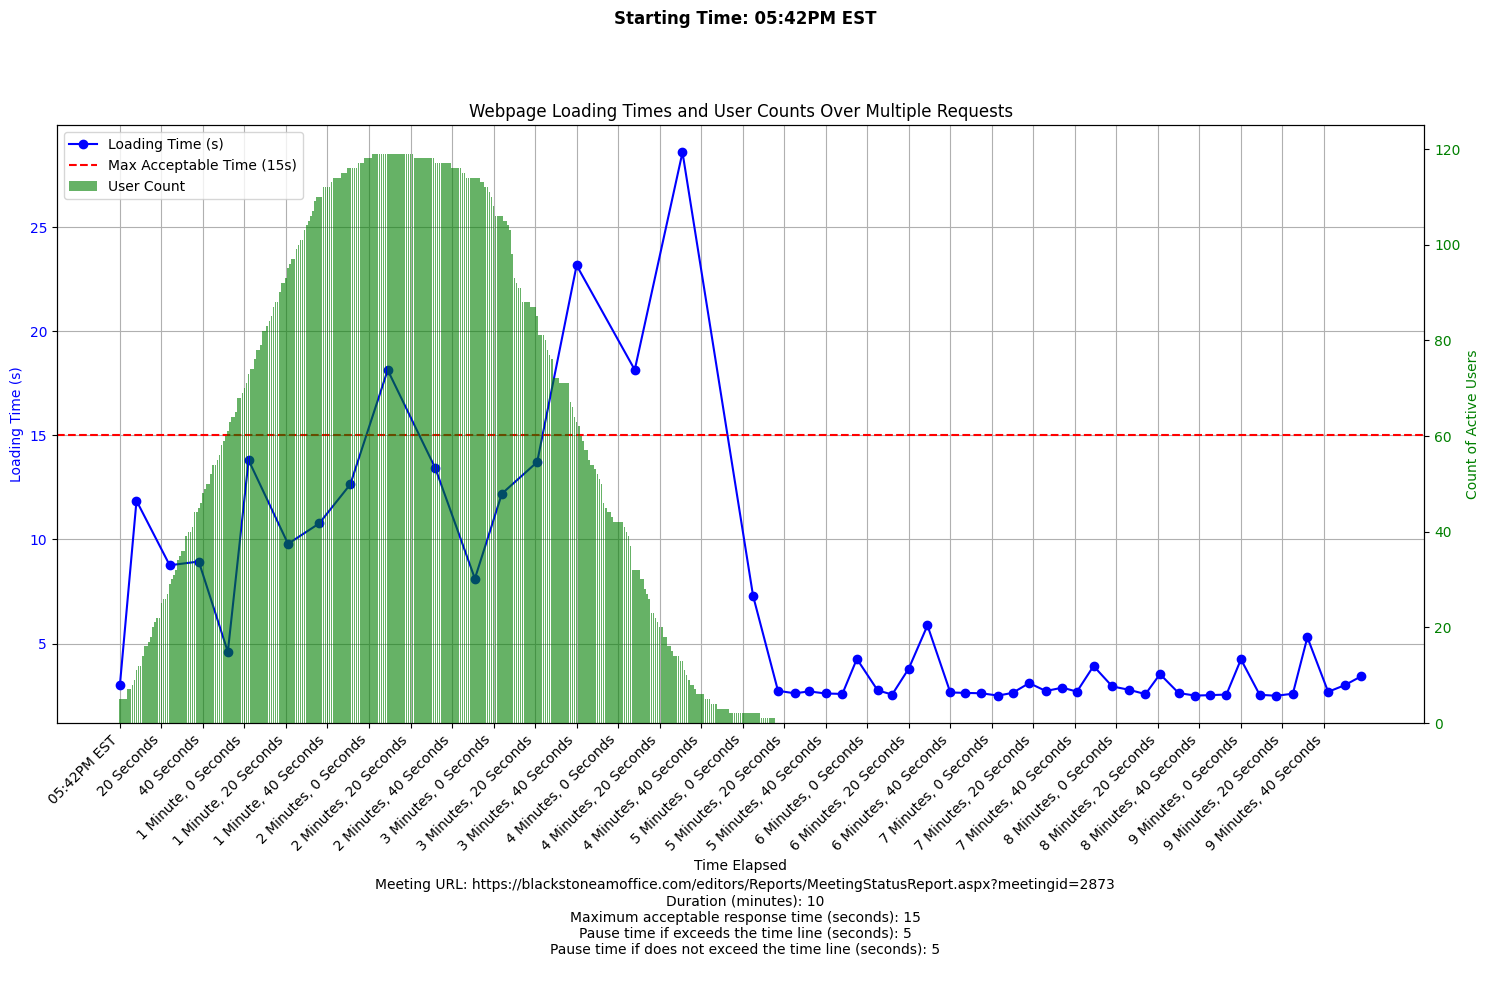

In [28]:
plot_user_count(timestamps, loading_time,counting_data,url, minutes, TIME_LINE, PAUSE_TIME_EXCEED, PAUSE_TIME_NOT_EXCEED)